In [1]:
np=7
using Pkg
Pkg.activate("..")
using Distributed
if nprocs() < np
    addprocs(np-nprocs())
end
@everywhere using Revise, FUSE
using Plots; plotlyjs();
println("Working with $(nprocs()) processes")

WebIO._IJuliaInit()

Working with 7 processes


  Activating project at `~/Coding/julia/FUSE`
┌ Info: Precompiling FUSE [e64856f0-3bb8-4376-b4b7-c03396503992]
└ @ Base loading.jl:1423


In [2]:
# dd,ini,act = FUSE.init(:ITER; init_from=:ods, do_plot=true)
# dd,ini,act = FUSE.init(:ITER; init_from=:scalars, do_plot=true)
# dd,ini,act = FUSE.init(:D3D; do_plot=true)
dd,ini,act = FUSE.init(:FPP; version=:v1_demount, do_plot=false)
act.TauennActor.rho_fluxmatch=0.43
# dd,ini,act = FUSE.init(:FPP; version=:v1, do_plot=true)
# dd,ini,act = FUSE.init(:CAT; do_plot=true)
# dd,ini,act = FUSE.init(:HDB5; tokamak=:JET, case=500, do_plot=true)

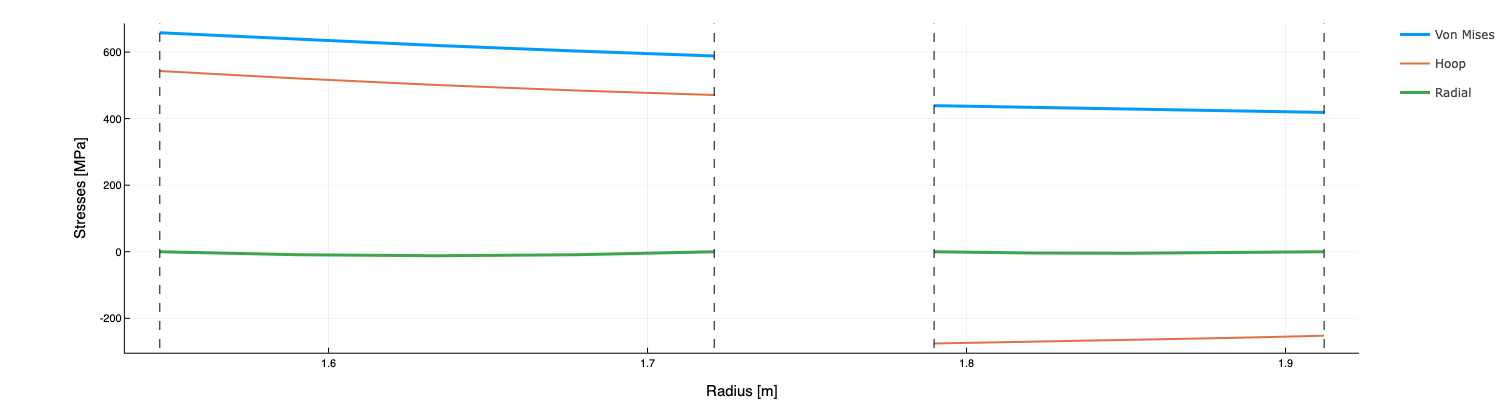

In [6]:
@everywhere function custom_workflow(dd,ini,act)
    FUSE.simple_equilibrium_transport_workflow(dd,ini,act)
    FUSE.init_pf_active(dd,ini,act)
    FUSE.HFSsizingActor(dd,act)
    FUSE.LFSsizingActor(dd,act)
    FUSE.CXbuildActor(dd,act)
    FUSE.CostingActor(dd,act)
end

custom_workflow(dd,ini,act)
plot(dd.build)

In [2]:
OFL=FUSE.ObjectivesFunctionsLibrary
objective_functions = [OFL[:max_fusion], OFL[:min_cost], OFL[:max_flattop]]
results=FUSE.optimization_workflow(custom_workflow,dd,ini,act,objective_functions;N=10,iterations=10);

LoadError: UndefVarError: FUSE not defined

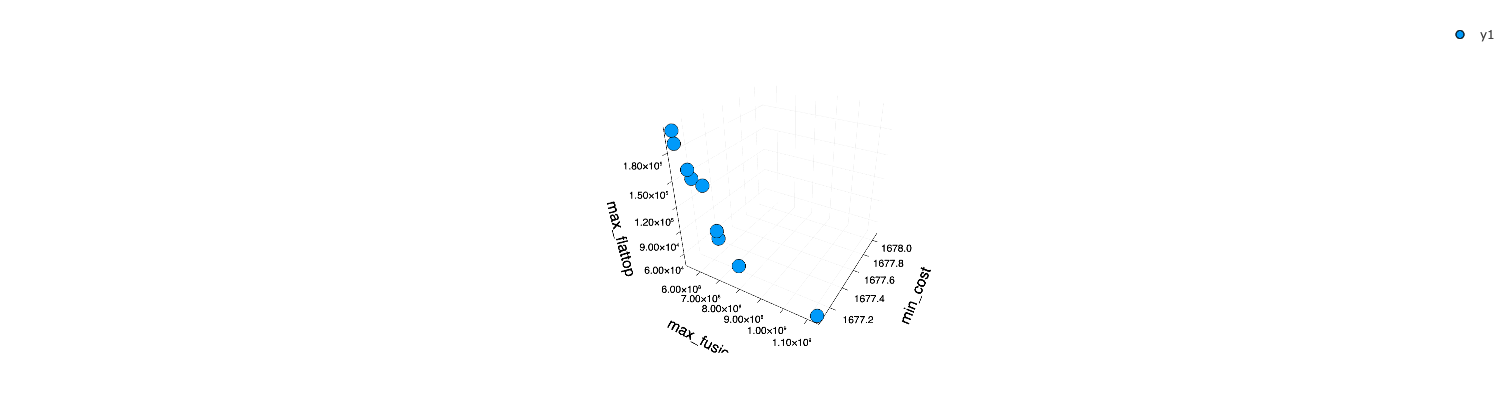

In [10]:
A = FUSE.Metaheuristics.pareto_front(results)
A=[objective_functions[k].(A[:,k]) for k in 1:size(A)[2]]
#x=[results.population[k].x[2] for k in 1:length(results.population)]
#scatter(x,A[:,1]./abs(A[1,1]))
#display(scatter!(x,A[:,2]./abs(A[1,2])))
#display(scatter(A[:, 1], -A[:,2], marker_z=x,label=""))
display(scatter(A[1],A[2],A[3],xlabel=objective_functions[1].name,ylabel=objective_functions[2].name,zlabel=objective_functions[3].name))